In [1]:
# %load /home/jonathan/.ipython/profile_default/startup/01-setup.py
# start up settings for jupyter notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys

# use plt.style.available() to check out available styles
plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.labelsize'] = 15.0
plt.rcParams['xtick.labelsize'] = 15.0
plt.rcParams['ytick.labelsize'] = 15.0
plt.rcParams['legend.fontsize'] = 15.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000

# to avoid have warnings from chained assignments
pd.options.mode.chained_assignment = None


In [2]:
idx = pd.IndexSlice

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

### Load the data

In [4]:
fp = '../prediction-data/final-data.csv'
uniq_fp = '../prediction-data/uniq-final-data.csv'

base_df = pd.read_csv(fp, header=[0, 1])
base_df.rename(columns={
    'Unnamed: 0_level_1': '',
    'Unnamed: 1_level_1': '',
    'Unnamed: 2_level_1': '',
    'Unnamed: 3_level_1': ''
}, level=1, inplace=True)

uniq_base_df = pd.read_csv(uniq_fp, header=[0, 1])
uniq_base_df.rename(columns={
    'Unnamed: 0_level_1': '',
    'Unnamed: 1_level_1': '',
    'Unnamed: 2_level_1': '',
    'Unnamed: 3_level_1': ''
}, level=1, inplace=True)

def convert_time_cols(df):
    # convert time columns from us to s
    time_cols = list(filter(lambda c: 'time' in c.lower() and not 'number of times' in c.lower(), df.columns.get_level_values(level=1)))
    for time_col in time_cols:
        df.loc[:, (time_col, 'astar')] /= 1000000
        df.loc[:, (time_col, 'inc3')] /= 1000000
        df.loc[:, (time_col, 'recomp-astar')] /= 1000000
        df.loc[:, (time_col, 'recomp-inc3')] /= 1000000

    # rename from us to s
    renamed_time_cols = list(map(lambda col: col.replace('(us)', '(s)'), time_cols))
    renamed_cols_dict = dict(zip(time_cols, renamed_time_cols))
    df.rename(columns=renamed_cols_dict, level=0, inplace=True)
    df.rename(columns=renamed_cols_dict, level=1, inplace=True)
    
convert_time_cols(base_df)
convert_time_cols(uniq_base_df)

base_df.set_index(['model', 'log', 'decomposition', 'SP label'], inplace=True)
uniq_base_df.set_index(['model', 'log', 'decomposition', 'SP label'], inplace=True)

# filter by k=2
k = 2
k_diff = base_df.loc[:, ('Total Time including setup (s)', 'max_diff')] >= k
k2_df = base_df.loc[k_diff, :]

k_diff_uniq = uniq_base_df.loc[:, ('Total Time including setup (s)', 'max_diff')] >= k
k2_uniq_df = uniq_base_df.loc[k_diff_uniq, :]

print('Base df shape: {}'.format(base_df.shape))
print('Uniq base df shape: {}'.format(uniq_base_df.shape))
print('K-2 df shape: {}'.format(k2_df.shape))
print('K-2 unique df shape: {}'.format(k2_uniq_df.shape))

/home/jonathan/2018/code/alignment-algorithm-classifier/alignclf-venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Base df shape: (245478, 258)
Uniq base df shape: (185848, 258)
K-2 df shape: (86469, 258)
K-2 unique df shape: (74582, 258)


### Map the class names to values

In [5]:
class_map = {
    'astar': 0,
    'inc3': 1,
    'recomp-astar': 2,
    'recomp-inc3': 3
}

base_df.loc[:, ('Min', 'Total Time including setup (s) - id')] = base_df.loc[: , idx['Min', 'Total Time including setup (s)']].map(class_map)
base_df.loc[:, ('is_valid', 'all')] = base_df.loc[:, idx[('is_valid'), ('astar', 'inc3', 'recomp-astar', 'recomp-inc3')]].apply(lambda row: row.all(), axis=1)


/home/jonathan/2018/code/alignment-algorithm-classifier/alignclf-venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


### Get class distribution of the data

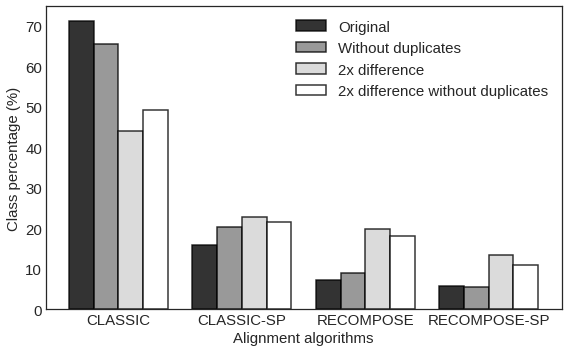

In [11]:
class_counts = base_df.loc[:,('Min', 'Total Time including setup (s)')].value_counts().values
percentile_classes = class_counts / class_counts.sum() * 100.

class_counts_uniq = uniq_base_df.loc[:,('Min', 'Total Time including setup (s)')].value_counts().values
percentile_classes_uniq = class_counts_uniq / class_counts_uniq.sum() * 100.

class_counts_k2 = k2_df.loc[:,('Min', 'Total Time including setup (s)')].value_counts().values
percentile_classes_k2 = class_counts_k2 / class_counts_k2.sum() * 100.

class_counts_k2_uniq = k2_uniq_df.loc[:, ('Min', 'Total Time including setup (s)')].value_counts().values
percentile_classes_k2_uniq = class_counts_k2_uniq / class_counts_k2_uniq.sum() * 100.

def visualize_classes(percentile_classes, percentile_classes_uniq, percentile_classes_k, percentile_classes_k_uniq):
    fig, ax = plt.subplots(figsize=(8, 5))

    algo_types = [
        'CLASSIC', 'CLASSIC-SP', 'RECOMPOSE', 'RECOMPOSE-SP'
    ]
    data_type = ['Original', 'Without duplicates', '2x difference', '2x difference without duplicates']

    hatches = ['/', 'x', '\\', '.']
    colors = ['black', 'gray', 'lightgray', 'white']
    width = 0.2
    alpha = 0.8
    xticks = algo_types
    yticks = [i * 0.1 for i in range(11)]
    ind = np.arange(4)
    edgecolor = 'black'
    linewidth = 1.5
    fontsize=15

    rects1 = ax.bar(ind, percentile_classes, width, color=colors[0], alpha=alpha, 
                    edgecolor=edgecolor, linewidth=linewidth)
    rects2 = ax.bar(ind + width, percentile_classes_uniq, width, color=colors[1], 
                   alpha=alpha, edgecolor=edgecolor, linewidth=linewidth)
    rects3 = ax.bar(ind + 2 * width, percentile_classes_k, width, color=colors[2],
                   alpha=alpha, edgecolor=edgecolor, linewidth=linewidth)
    rects4 = ax.bar(ind + 3 * width, percentile_classes_k_uniq, width, color=colors[3], 
                   alpha=alpha, edgecolor=edgecolor, linewidth=linewidth)

    ax.set_xticks(ind + 1.5 * width)
    ax.set_xticklabels(xticks)
    ax.set_ylabel('Class percentage (%)', fontsize=fontsize)
    ax.set_xlabel('Alignment algorithms', fontsize=fontsize)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)
        tick.label.set_horizontalalignment('center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)

    ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), data_type, fontsize=fontsize);
    
    return fig, ax

fig, ax = visualize_classes(percentile_classes, percentile_classes_uniq, percentile_classes_k2, percentile_classes_k2_uniq)
out_fp = './class-dist.svg'
fig.tight_layout()
# fig.savefig(out_fp, bbox_inches='tight', rasterized=True)

### Load trained model

In [6]:
import pickle
from sklearn import tree
import sklearn
from sklearn.model_selection import GridSearchCV
import graphviz
import time

In [7]:
# 2-difference dataset
dirpath_dt = '../ml-results/ICPM-results/2019-02-05_10-22-10-795220_tree/'
dirpath_rf = '../ml-results/ICPM-results/2019-02-04_17-40-52-125116_random-forest/'

dt_fp = os.path.join(dirpath_dt, 'gridsearch.sav')
rf_fp = os.path.join(dirpath_rf, 'forest.sav')

with open(dt_fp, 'rb') as f:
    dt_gridsearch = pickle.load(f)
    dt = dt_gridsearch.best_estimator_
    
with open(rf_fp, 'rb') as f:
    rf = pickle.load(f)

In [8]:
def get_feature_cols(columns):
    not_min_max = lambda c: not c.endswith('min') and not c.endswith('max')
    not_one_deg = lambda c: not c.endswith('one_in_deg') and not c.endswith('one_out_deg')
    not_two_deg = lambda c: not c.endswith('two_in_deg') and not c.endswith('two_out_deg')
    not_three_deg = lambda c: not c.endswith('three_in_deg') and not c.endswith('three_out_deg')
    not_more_than_five_deg = lambda c: not c.endswith('five_in_deg') and not c.endswith('five_out_deg')

    joined_filter = lambda c: not_min_max(c) and not_one_deg(c) \
                              and not_two_deg(c) and not_three_deg(c) \
                              and not_more_than_five_deg(c)

    return list(filter(joined_filter, columns))

columns = base_df.loc[:, idx['model_trace_features', :]].columns.get_level_values(level=1)
feature_names = get_feature_cols(columns)

dt_feature_importance_df = pd.DataFrame({
    'feature_name': feature_names,
    'importance': dt.feature_importances_
})

rf_feature_importance_df = pd.DataFrame({
    'feature_name': feature_names,
    'importance': rf.feature_importances_
})

feature_importance_df = dt_feature_importance_df.merge(rf_feature_importance_df, on='feature_name', suffixes=('_dt', '_rf'))
feature_importance_df = feature_importance_df.sort_values('importance_dt', ascending=False).set_index('feature_name')

### Top 5 most important features

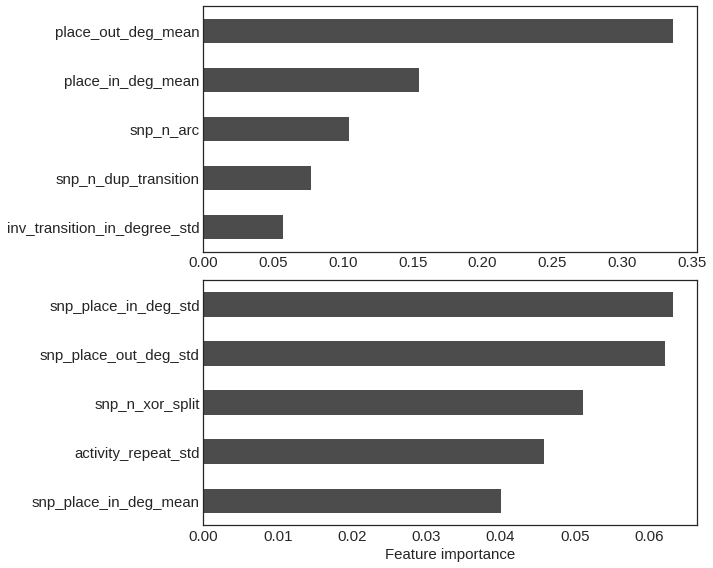

In [10]:
top_n = 5
top_5_feature_dt_df = feature_importance_df.sort_values('importance_dt', ascending=False).iloc[:top_n,:].sort_values('importance_dt')
top_5_feature_rf_df = feature_importance_df.sort_values('importance_rf', ascending=False).iloc[:top_n,:].sort_values('importance_rf')

fig, axes = plt.subplots(figsize=(10, 8), nrows=2)

top_5_feature_dt_df.plot.barh(y='importance_dt', ax=axes[0], color='black', alpha=0.7, legend=False, fontsize=15)
top_5_feature_rf_df.plot.barh(y='importance_rf', ax=axes[1], color='black', alpha=0.7, legend=False, fontsize=15)

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xlabel('Feature importance', fontsize=15)

for tick in axes[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in axes[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

out_fp = './important-feature-top-5.svg'
fig.tight_layout()
# fig.savefig(out_fp, bbox_inches='tight', rasterized=True)

### Confusion matrix of the paper
For the rest of the confusion matrices, use the confusion matrix script

In [17]:
def get_feature_cols(columns):
    not_min_max = lambda c: not c.endswith('min') and not c.endswith('max')
    not_one_deg = lambda c: not c.endswith('one_in_deg') and not c.endswith('one_out_deg')
    not_two_deg = lambda c: not c.endswith('two_in_deg') and not c.endswith('two_out_deg')
    not_three_deg = lambda c: not c.endswith('three_in_deg') and not c.endswith('three_out_deg')
    not_more_than_five_deg = lambda c: not c.endswith('five_in_deg') and not c.endswith('five_out_deg')

    joined_filter = lambda c: not_min_max(c) and not_one_deg(c) \
                              and not_two_deg(c) and not_three_deg(c) \
                              and not_more_than_five_deg(c)

    return list(filter(joined_filter, columns))


def ns_to_s(df):
    time_cols = list(filter(lambda c: 'time' in c.lower() and not 'number of times' in c.lower(), df.columns.get_level_values(level=1)))
    for time_col in time_cols:
        df.loc[:, (time_col, 'astar')] /= 1000000
        df.loc[:, (time_col, 'inc3')] /= 1000000
        df.loc[:, (time_col, 'recomp-astar')] /= 1000000
        df.loc[:, (time_col, 'recomp-inc3')] /= 1000000

    renamed_time_cols = list(map(lambda col: col.replace('(us)', '(s)'), time_cols))
    renamed_cols_dict = dict(zip(time_cols, renamed_time_cols))
    df.rename(columns=renamed_cols_dict, level=0, inplace=True)
    df.rename(columns=renamed_cols_dict, level=1, inplace=True)


def import_data(fp, convert_time=True):
    df = pd.read_csv(fp, header=[0, 1])
    df.rename(columns={
        'Unnamed: 0_level_1': '',
        'Unnamed: 1_level_1': '',
        'Unnamed: 2_level_1': '',
        'Unnamed: 3_level_1': ''
    }, level=1, inplace=True)

    if convert_time:
        ns_to_s(df)

    df.set_index(['model', 'log', 'decomposition', 'SP label'], inplace=True)

    return df


def filter_row_by_k_time_diff(df, k):
    k_diff = df.loc[:, ('Total Time including setup (s)', 'max_diff')] >= k
    return df.loc[k_diff, :]


def get_uniq_count(l):
    uniq, count = np.unique(l, return_counts=True)
    return dict(zip(uniq, count))


def plot_confusion_matrix(cm, classes, normalized=False, cmap=plt.cm.Blues):
    if normalized:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(10, 8))

    if normalized:
        img = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    else:
        img = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    cbar = fig.colorbar(img)
    cbar.ax.tick_params(labelsize=15)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalized else 'd'
    thresh = cm.max() / 2.
    for i, j in itls.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=15)
        ax.set_ylabel('True label', fontsize=15)
        ax.set_xlabel('Predicted label', fontsize=15)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)
        tick.label.set_rotation(45)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)

    fig.tight_layout()

    return fig, ax

In [21]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools as itls

### Confusion matrix of the 2x difference dataset

Normalized confusion matrix


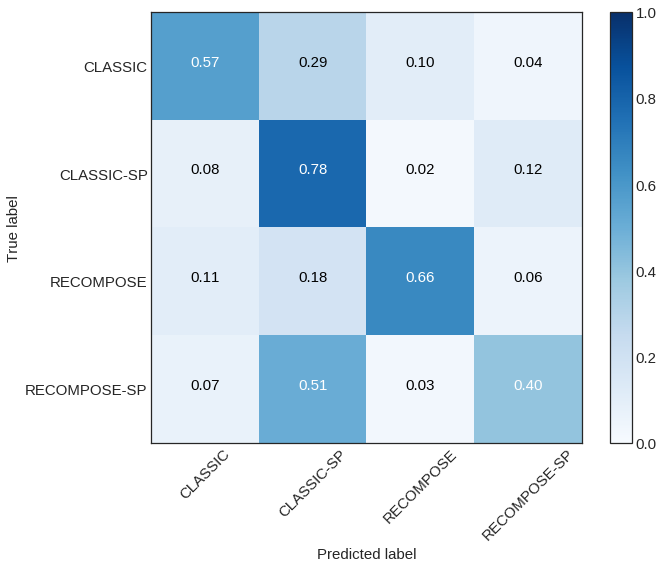

In [30]:
columns = k2_df.loc[:, idx['model_trace_features', :]].columns.get_level_values(level=1)
columns = get_feature_cols(list(columns))

X = k2_df.loc[:, idx['model_trace_features', columns]]
y = k2_df.loc[:, ('Min', 'Total Time including setup (s)')].map(class_map)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

y_pred = rf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

outdir = '.'
# print('Confusion mat: \n{}'.format(cnf_matrix))

class_names = [
    'CLASSIC', 'CLASSIC-SP', 'RECOMPOSE', 'RECOMPOSE-SP'
]
fig, ax = plot_confusion_matrix(cnf_matrix, classes=class_names, normalized=True)
out_fp = os.path.join(outdir, 'cnf-mat.svg')
# fig.savefig(out_fp, bbox_inches='tight', rasterized=True)

out_fp = os.path.join(outdir, 'cnf-mat.txt')
cnf_mat_df = pd.DataFrame(cnf_matrix)
cnf_mat_df['data_class'] = class_names
cnf_mat_df.set_index('data_class', inplace=True)
cnf_mat_df.columns = class_names
# cnf_mat_df.to_csv(out_fp, index=True)